In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')

q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q, c)
job = execute(circuit, backend, shots=100)
result = job.result()
print(result.get_counts(circuit))

{'0': 100}


/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


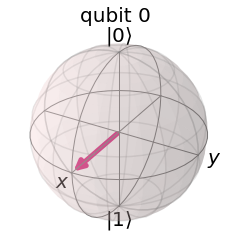

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_bloch_multivector


backend_statevector = BasicAer.get_backend('statevector_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q, c)
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

circuit.h(q[0])
job = execute(circuit, backend_statevector)
plot_bloch_multivector(job.result().get_statevector(circuit))

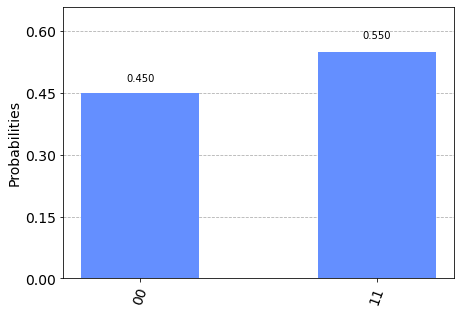

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit.measure(q, c)
circuit.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from sklearn.svm import SVC
from qiskit import Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels

from sklearn.preprocessing import StandardScaler

# Read Data
Titanic_DF = pd.read_csv('titanic.csv')
from sklearn import preprocessing
lb_make = preprocessing.LabelEncoder()
Titanic_DF['Sex'] = lb_make.fit_transform(Titanic_DF['Sex'])
le_name_mapping = dict(zip(lb_make.classes_, lb_make.transform(lb_make.classes_)))

FeatureNames = [x for x in list(Titanic_DF.columns) if x not in ['Name','Survived']]
Data = Titanic_DF[FeatureNames].values
Labels = Titanic_DF['Survived'].values

{'female': 0, 'male': 1}


In [19]:
Titanic_DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def PrepareData(training_size, test_size, n):
    class_labels = [r'0', r'1']
    sample_train, sample_test, label_train, label_test = train_test_split(Data, Labels, test_size=0.3, random_state=12)

    # Now we standarize for gaussian around 0 with unit variance
    print(sample_train, sample_test, label_train, label_test)
    std_scale = StandardScaler().fit(sample_train, label_train)
    print(std_scale)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    return sample_train, sample_test, label_train, label_test, class_labels
    
def QuantumFormat(sample_train, sample_test, label_train, label_test, training_size, test_size, class_labels):
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)}
    return training_input, test_input

In [33]:
# Set up
feature_dim=2
sample_train, sample_test, label_train, label_test, class_labels = PrepareData(training_size=10, test_size=10, n=feature_dim)
training_input, test_input = QuantumFormat(sample_train, sample_test, label_train, label_test, 10, 10, class_labels)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

ValueError: could not convert string to float: 'C'

In [ ]:
# QSVM
feature_map = SecondOrderExpansion(feature_dim, depth=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, None)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = qsvm.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.savefig('kernelQSVM.pdf')
plt.show()

In [16]:

# Classical SVM
svc = SVC(probability=True, gamma='auto')
svc.fit(sample_train, label_train)
kernel_matrix2=sklearn.metrics.pairwise.rbf_kernel(sample_train, sample_train)
img = plt.imshow(np.asmatrix(kernel_matrix2[0:10,0:10]),interpolation='nearest',origin='upper',cmap='bone_r')
plt.savefig('kernelSVM.pdf')
plt.show()

# Error Rate
label_predict=svc.predict(sample_test)
print('Error rate: ' + str(sum(label_predict==label_test)/len(label_predict)))

NameError: name 'sample_train' is not defined